# PyTorch TensorBoard 支持

要运行本教程，您需要安装 PyTorch、TorchVision、Matplotlib 和 TensorBoard。

使用 `conda`：

```bash
conda install pytorch torchvision -c pytorch
conda install matplotlib tensorboard
```

使用 `pip`：

```bash
pip install torch torchvision matplotlib tensorboard
```

安装依赖项后，请在安装它们的 Python 环境中重新启动此笔记本。

## 简介

在本笔记本中，我们将针对 Fashion-MNIST 数据集训练 LeNet-5 的一个变体。Fashion-MNIST 是一组描绘各种服装的图像块，具有十个类别标签，表示所描绘的服装类型。

In [2]:
# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

# In case you are using an environment that has TensorFlow installed,
# such as Google Colab, uncomment the following code to avoid
# a bug with saving embeddings to your TensorBoard directory

# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

2024-12-06 19:40:49.978743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733485250.284943 1239909 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733485250.357974 1239909 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 19:40:51.162400: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from set_env import temp_dir

## 在 TensorBoard 中显示图像

首先将数据集中的样本图像添加到 TensorBoard：

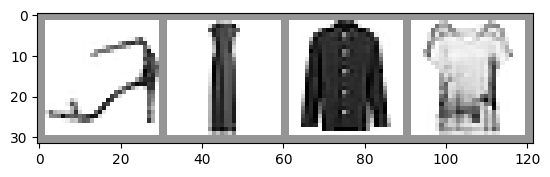

In [4]:
# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Store separate training and validations splits in ./data
training_set = torchvision.datasets.FashionMNIST(temp_dir/'./data',
    download=True,
    train=True,
    transform=transform)
validation_set = torchvision.datasets.FashionMNIST(temp_dir/'./data',
    download=True,
    train=False,
    transform=transform)

training_loader = torch.utils.data.DataLoader(training_set,
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=2)


validation_loader = torch.utils.data.DataLoader(validation_set,
                                                batch_size=4,
                                                shuffle=False,
                                                num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Extract a batch of 4 images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

在上面的代码中，我们使用 TorchVision 和 Matplotlib 创建了一个输入数据小批次的可视化网格。下面，使用 `SummaryWriter` 的 `add_image()` 调用来记录图像以供 TensorBoard 使用，并且我们还调用 `flush()` 以确保它立即写入磁盘。

In [5]:
# Default log_dir argument is "runs" - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter(temp_dir/'runs/fashion_mnist_experiment_1')

# Write image data to TensorBoard log dir
writer.add_image('Four Fashion-MNIST Images', img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/

如果在命令行启动 TensorBoard 并在新浏览器标签页中打开它（通常在 <localhost:6006>），您应该会在 IMAGES 标签下看到图像网格。

## 绘制标量以可视化训练

TensorBoard 对于跟踪训练进度和效果非常有用。下面，我们将运行一个训练循环，跟踪一些指标，并保存数据以供 TensorBoard 使用。

定义模型来对我们的图像块进行分类，并定义优化器和损失函数用于训练：

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

训练一个 epoch，并每 1000 个批次评估训练集和验证集的损失：

In [7]:
print(len(validation_loader))
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(training_loader, 0):
        # basic training loop
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # Every 1000 mini-batches...
            print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0
            
            # In evaluation mode some model specific operations can be omitted eg. dropout layer
            net.train(False) # Switching to evaluation mode, eg. turning off regularisation
            for j, vdata in enumerate(validation_loader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True) # Switching back to training mode, eg. turning on regularisation
            
            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validation_loader)
            
            # Log the running loss averaged per batch
            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(training_loader) + i)

            running_loss = 0.0
print('Finished Training')

writer.flush()

2500
Batch 1000
Batch 2000
Batch 3000
Batch 4000
Batch 5000
Batch 6000
Batch 7000
Batch 8000
Batch 9000
Batch 10000
Batch 11000
Batch 12000
Batch 13000
Batch 14000
Batch 15000
Finished Training


切换到您打开的 TensorBoard 并查看 SCALARS 标签。

## 可视化您的模型

TensorBoard 还可以用于检查模型内部的数据流。为此，请使用模型和样本输入调用 `add_graph()` 方法：

In [8]:
# Again, grab a single mini-batch of images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# add_graph() will trace the sample input through your model,
# and render it as a graph.
writer.add_graph(net, images)
writer.flush()

当您切换到 TensorBoard 时，您应该会看到一个 GRAPHS 标签。双击 "NET" 节点以查看模型内部的层和数据流。

## 使用嵌入可视化您的数据集

我们使用的 28x28 图像块可以建模为 784 维向量（$28 \times 28 = 784$）。将其投影到较低维度的表示中可能会有启发性。`add_embedding()` 方法将数据集投影到方差最高的三个维度，并以交互式 3D 图表显示它们。`add_embedding()` 方法通过投影到方差最高的三个维度来自动完成此操作。

下面，我们将对数据进行采样，并生成这样的嵌入：

In [9]:
# Select a random subset of data and corresponding labels
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# Extract a random subset of data
images, labels = select_n_random(training_set.data, training_set.targets)

# get the class labels for each image
class_labels = [classes[label] for label in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.flush()
writer.close()

现在，如果您切换到 TensorBoard 并选择 PROJECTOR 标签，您应该会看到投影的三维表示。您可以旋转和缩放模型。在大尺度和小尺度下检查它，看看您是否能在投影数据和标签聚类中找到模式。

为了更好的可见性，建议：

- 从左侧的“Color by”下拉菜单中选择“label”。
- 沿顶部切换 Night Mode 图标，将浅色图像放在深色背景上。

## 其他资源

有关更多信息，请查看：

- PyTorch 文档中的 [torch.utils.tensorboard.SummaryWriter](https://pytorch.org/docs/stable/tensorboard.html?highlight=summarywriter)
- [PyTorch.org 教程](https://pytorch.org/tutorials/) 中的 TensorBoard 教程内容
- 有关 TensorBoard 的更多信息，请参阅 [TensorBoard 文档](https://www.tensorflow.org/tensorboard)